In [1]:
!pip install unyt
!pip install gpflow
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import unyt as u
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

def shuffle_and_split(df, n_params, fraction_train=0.8):
    # Return values for all samples (liquid and vapor)
    data = df.values
    fraction_test = 1.0 - fraction_train
    total_entries = data.shape[0]
    train_entries = int(total_entries * fraction_train)
    # Shuffle the data before splitting train/test sets
    #np.random.shuffle(data)

    # x = params, y = output
    x_train = data[:train_entries, : n_params].astype(np.float64)
    y_train = data[:train_entries, -1].astype(np.float64)
    x_test = data[train_entries:, : n_params].astype(np.float64)
    y_test = data[train_entries:, -1].astype(np.float64)

    return x_train, y_train, x_test, y_test

def run_gpflow_scipy(x_train, y_train, kernel):
    # Create the model
    model = gpflow.models.GPR(
        data=(x_train, y_train.reshape(-1, 1)),
        kernel=kernel,
        mean_function=gpflow.mean_functions.Linear(
            A=np.zeros(x_train.shape[1]).reshape(-1, 1)
        ),
    )

    # Print initial values
    print_summary(model, fmt="notebook")

    # Optimize model with scipy
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(model.training_loss, model.trainable_variables)

    # Print the optimized values
    print_summary(model, fmt="notebook")

    # Return the model
    return model

def plot_models(models, x_data, y_data, xylim_low=0, xylim_high=1):
    plt.plot(
        np.arange(xylim_low, xylim_high + 100, 100),
        np.arange(xylim_low, xylim_high + 100, 100),
        color="xkcd:blue grey",
        label="y=x",
    )

    for (label, model) in models.items():
        gp_mu, gp_var = model.predict_f(x_data)
        y_data_physical = y_data
        gp_mu_physical = gp_mu
        plt.scatter(y_data_physical, gp_mu_physical, label=label)
        sumsqerr = np.sum((gp_mu_physical - y_data_physical.reshape(-1, 1)) ** 2)
        print("Model: {}. Sum squared err: {:f}".format(label, sumsqerr))

    plt.xlim(xylim_low, xylim_high)
    plt.ylim(xylim_low, xylim_high)
    plt.xlabel("Actual")
    plt.ylabel("Model Prediction")
    plt.legend()
    ax = plt.gca()
    ax.set_aspect("equal", "box")

def plot_function(models,train,test):
    #x data samples
    xx = np.linspace(0, 400.0, 100)[:,None]
    
    for (label, model) in models.items():
        
        #use model to predict output (y) given x data
        mean, var = model.predict_f(xx)
        #plot mean as line
        plt.plot(xx, mean, lw=2, color="orange", label="GP model" + label)
        #plot variance as a shaded area
        plt.fill_between(
            xx[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            alpha=0.25,
        )

    #Plot training and testing points
    if train.shape[0] > 0:
        x_train = train[:, 0]
        y_train = train[:, 1]
        plt.plot(x_train, y_train, color="black", label="Train")
    if test.shape[0] > 0:
        x_test = test[:, 0]
        y_test = test[:, 1]
        plt.plot(x_test, y_test, label="Test")
        
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[9.94218]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1129.9285]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,165859.00211
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[5.27282]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,315.08289


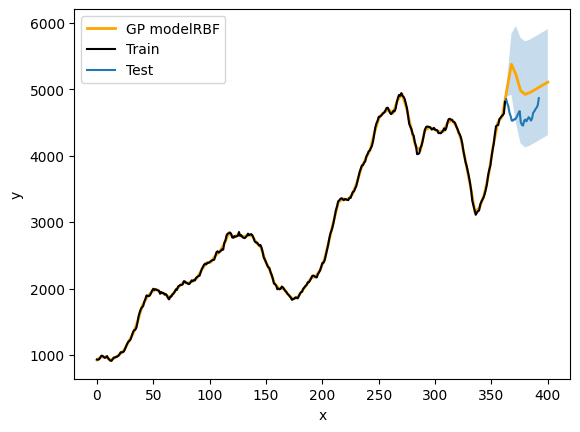

In [4]:
with open('website_data.csv') as f:
  x = f.readline()
  lx = []
  ly = []
  for i in range(0,393):
    x = f.readline()
    ly.append([int(x)])
    lx.append([i])
x = np.array(lx)
y = np.array(ly)

data = np.concatenate((x,y),axis=1)
data = pd.DataFrame(data,columns=['x','y'])

n_params = 1
#Apply shuffle_and_split function
x_train, y_train, x_test, y_test = shuffle_and_split(data, n_params, fraction_train=0.924)

model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model = {'RBF': model_RBF}

#data.plot()
#plot_models(model, x_train, y_train,0,5000)
#plot_models(model, x_test, y_test,0,5000)

y_train.shape = (363,1)
y_test.shape = (30,1)
#Make arrays
train = np.concatenate((x_train,y_train),axis=1)
test = np.concatenate((x_test,y_test),axis=1)
 
plot_function(model,train,test)